[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/francisco-ortin/data-science-course/blob/main/deep-learning/rnn/language_model.ipynb)
[![License: CC BY-NC-SA 4.0](https://img.shields.io/badge/License-CC%20BY--NC--SA%204.0-lightgrey.svg)](https://creativecommons.org/licenses/by-nc-sa/4.0/)

# Language model

[Language models](https://en.wikipedia.org/wiki/Language_model) are a key element of [Natural Language Processing](https://en.wikipedia.org/wiki/Natural_language_processing) (NLP). They are probabilistic models of natural languages (they predict the likelihood of a sequence of words). They are widely used to understand and generate coherent text. They are used in many NLP scenarios such as language translation, text summarization, text rephrasing for clarity and correctness and text prediction, among others.

In this notebook, we develop char-based language model for English text written by [Oscar Wilde](https://en.wikipedia.org/wiki/Oscar_Wilde), using an RNN. Char-based language models are those where tokens are the characters used in the text. They have smaller vocabulary sizes, but they require longer sequences to process the same text.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/9/9c/Oscar_Wilde_portrait.jpg/250px-Oscar_Wilde_portrait.jpg">

In [1]:
# make sure the required packages are installed
%pip install pandas numpy seaborn matplotlib scikit-learn keras tensorflow --quiet
# if running in colab, install the required packages and copy the necessary files
directory='data-science-course/deep-learning/rnn'
if get_ipython().__class__.__module__.startswith('google.colab'):
    !git clone --depth 1 https://github.com/francisco-ortin/data-science-course.git  2>/dev/null
    !cp --update {directory}/*.py .
    !mkdir -p img data
    !cp {directory}/data/* data/.
    !cp {directory}/img/* img/.

import os
import keras
from keras import layers, Model
import numpy as np
import io
import matplotlib.pyplot as plt
from keras.src.saving import load_model

Note: you may need to restart the kernel to use updated packages.


## Important variables

We define the following variables:
- `no_input_char` is the zero character that we use to model no input (the common `0` input that is passed to the RNN at the first time step.
- `max_input_length` is the maximum length of the input sequences (English text). Although RNNs allow for variable length sequences, we use a fixed length to speed up training.
- `text_file_name` is the name of the file containing the English text by Oscar Wilde.
- `model_file_name` is the name of the file where the trained model is saved (if any). This notebook allows you to train the model from scratch or load a previously trained model (it takes some time to train the model). 

In [2]:
# character used to represent the absence of input (first time step)
no_input_char = "\x00"
# maximum length of the input sequences; although RNNs allow for variable length sequences, we use a fixed length to speed up training
max_input_length = 40
# English text by Oscar Wilde
text_file_name = 'data/oscar-wilde.txt'
# path to the model file (if any)
model_file_name = 'data/wilde_language_model.keras'

## Load and process the text

We load the text by Oscar Wilde and preprocess it. We convert it to lowercase and remove newline characters. We also print the length of the text and the number of unique characters in the text (the vocabulary).

In [3]:
def load_file(file_path: str) -> str:
    with io.open(file_path, encoding="utf-8") as f:
        file_contents = f.read().lower()
    return file_contents.replace("\n", " ")  # We remove newlines chars because they are not needed for this task


text = load_file(text_file_name)
print(f"Corpus length: {len(text):,} characters.")
vocabulary_chars = sorted(list(set(text + no_input_char)))
print(f"Unique chars (vocabulary size): {len(vocabulary_chars)}.")

Corpus length: 514,308 characters.
Unique chars (vocabulary size): 130.


Let's visualize the occurrences of all the characters in the text in descending order.

C:\Program Files\Python311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Program Files\Python311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 0 ( ) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


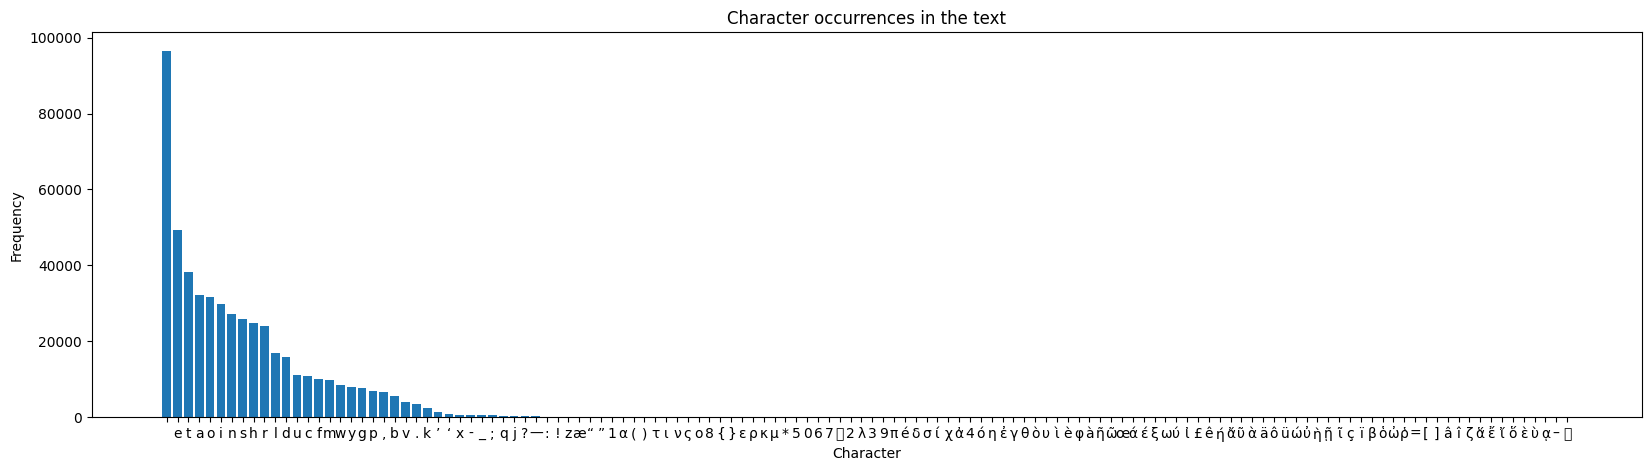

In [4]:
# show the frequencies of all the chars in descending order
char_frequencies = {char: text.count(char) for char in vocabulary_chars}
sorted_char_frequencies = sorted(char_frequencies.items(), key=lambda item: item[1], reverse=True)
# visualize the frequencies of the characters as a histogram using matplotlib
plt.figure(figsize=(20, 5))
plt.bar([char for char, _ in sorted_char_frequencies], [freq for _, freq in sorted_char_frequencies])
plt.xlabel("Character")
plt.ylabel("Frequency")
plt.title("Character occurrences in the text")
plt.show()

We create two dictionaries allows us to convert characters into numbers (indices) and vice versa, since we receive characters as input but we represent them as ordinal numbers.

In [5]:
char_to_index = dict((c, i) for i, c in enumerate(vocabulary_chars))
index_to_char = dict((i, c) for i, c in enumerate(vocabulary_chars))

## Prepare the data

The input and output data has to be prepared for model training. We generate sequences of characters of length `max_input_length` as input and the next character in the text as output. For each character, both in the input and the output, we convert them into one-hot encoding. Therefore, we have the following shapes:

- (num_sequences, max_input_length, num_unique_chars) for the input. First, the number of sequences, then the length of each sequences in characters, and finally the vocabulary size or number of unique characters (one-hot codification).
- (num_sequences, num_unique_chars) for the output. The number of sequences and, for each character, the vocabulary size (one-hot codification).

In [6]:
def convert_X_and_y_to_one_hot(input_sequences_p: list, output_chars_p: list, max_input_length_p: int) \
        -> tuple[np.array, np.array]:
    """
    Convert the input and output sequences to one-hot encoding
    :param input_sequences_p: intput sequences in shape (num_sequences, max_input_length)
    :param output_chars_p: output characters in shape (num_sequences)
    :param max_input_length_p: the maximum length of the input sequences
    :return: (X_ds, y_ds) the input sequence in one-hot encoding and the output (next) characters in one-hot encoding
    with shapes (num_sequences, max_input_length, num_unique_chars) and (num_sequences, num_unique_chars) respectively
    """
    # We perform one-hot encoding of the input sequences and output characters
    # shape (num_sequences, max_input_length, num_unique_chars); all values are zeros
    # we use a fixed length of 40 characters for each sequence to speed up training
    X_ds = np.zeros((len(input_sequences_p), max_input_length_p, len(vocabulary_chars)), dtype="bool")
    # shape (num_sequences, num_unique_chars); all values are zeros
    y_ds = np.zeros((len(input_sequences_p), len(vocabulary_chars)), dtype="bool")
    # we set to 1 the corresponding character index for each sequence
    for sequence_index, input_sequence in enumerate(input_sequences_p):
        for char_index, sequence_char in enumerate(input_sequence):
            X_ds[sequence_index, char_index, char_to_index[sequence_char]] = 1
        y_ds[sequence_index, char_to_index[output_chars_p[sequence_index]]] = 1
    return X_ds, y_ds


def generate_X_and_y(text: str, max_input_length_p: int) -> tuple[np.array, np.array]:
    """
    Generate the input and output sequences for the model
    :param text: the input text to be broken into sequences
    :param max_input_length_p: the maximum length of the input sequences
    :return: (X_ds, y_ds) the input sequence in one-hot encoding and the output (next) characters in one-hot encoding
    with shapes (num_sequences, max_input_length, num_unique_chars) and (num_sequences, num_unique_chars) respectively
    """
    input_sequences = []
    output_chars = []
    char_steps = 3
    # cut the text in semi-redundant sequences of maxlen characters
    for sequence_index in range(0, len(text) - max_input_length_p, char_steps):
        input_sequences.append(text[sequence_index: sequence_index + max_input_length_p])
        output_chars.append(text[sequence_index + max_input_length_p])
    print(f"Number of sequences: {len(input_sequences):,}.")
    # We perform one-hot encoding of the input sequences and output characters
    return convert_X_and_y_to_one_hot(input_sequences, output_chars, max_input_length_p)


X_dataset, y_dataset = generate_X_and_y(text, max_input_length)

Number of sequences: 171,423.


## Model construction and compilation

We create multi-LSTM RNN layer followed by a dense layer with softmax activation. The model is compiled using the RMSprop (Root Mean Square Propagation) optimizer and the categorical crossentropy loss function. RMSprop is an adaptive learning rate optimization algorithm that is used to train deep learning models. It is a variant of the stochastic gradient descent algorithm. RMSprop divides the learning rate by an exponentially decaying average of squared gradients. 

In [7]:
language_model = keras.Sequential([
        keras.Input(shape=(max_input_length, len(vocabulary_chars))),
        layers.LSTM(128),
        layers.Dense(len(vocabulary_chars), activation="softmax"),
    ]
)
optimizer = keras.optimizers.RMSprop(learning_rate=0.01)
language_model.compile(loss="categorical_crossentropy", optimizer=optimizer)

## Model training

We load the existing trained model from `model_file_name` if it exists, otherwise we train the model. Training the model takes some time, so we save the model to disk after training. If you want to train the model from scratch, you can delete the file `model_file_name` and run the code. We train the model for 100 epochs with a batch size of 128. 

In [8]:
# if we have a model, we load it from disk, otherwise we train it
if os.path.exists(model_file_name):
    language_model = load_model(model_file_name)
else:
    # we train the model and save it to disk
    epochs = 100
    batch_size = 128
    language_model.fit(X_dataset, y_dataset, batch_size=batch_size, epochs=epochs)
    language_model.save(model_file_name)

## Text generation

Now, we generate some text from the model. Is is a basic eager way of _generative AI_, where the model is used to generate new text, following the style of the training dataset (Oscar Wilde writing). 

We define a `prepare_input_text_to_one_hot` function that prepares the input text to be used as input for the language model (one sequence of characters coded in one-hot). We also define a function `sample` that samples one character from the logits (softmax output) of the model, considering a temperature. We define a function `generate_text` that generates text from a previous sequence of characters, using the language model. 

We generate text for different starting texts and temperatures. The temperature is a hyperparameter that controls the randomness of the predictions. A temperature of 1.0 is the original probabilities, <1.0 is conservative (more likely characters), and >1.0 is creative (less likely characters).

In [14]:
def prepare_input_text_to_one_hot(input_text_p: str) -> np.array:
    """
    Prepare the input text to be used as input for the language model
    :param input_text_p: the input text as str to be prepared
    :return: the one-hot encoded input text in shape (1, len(input_text), len(vocabulary_chars))
    """
    x_to_predict = np.zeros((1, len(input_text_p), len(vocabulary_chars)))
    for char_index, sequence_char in enumerate(input_text_p):
        x_to_predict[0, char_index, char_to_index[sequence_char]] = 1.0
    return x_to_predict


def sample(predictions: np.array, temperature_p: float = 1.0) -> int:
    """
    Helper function to sample an index from a probability array
    :param predictions: the array of probabilities predicted by the model (softmax output)
    :param temperature_p: the temperature to apply to the probabilities (1=original, <1=conservative, >1=creative)
    :return: the index of the selected character
    """
    # convert to float64 to avoid numerical issues
    predictions = np.asarray(predictions).astype("float64")
    # modify the probabilities according to the temperature
    # calculate the log of the probabilities and divide by the temperature
    predictions = np.log(predictions) / temperature_p
    # apply the softmax function (exp(x) / sum(exp(x))) to the modified probabilities
    exp_predictions = np.exp(predictions)
    predictions = exp_predictions / np.sum(exp_predictions)
    probas = np.random.multinomial(1, predictions, 1)  # probabilities after softmax (and temperature application)
    # return the index of the maximum value (the selected character)
    return np.argmax(probas)


def generate_text(starting_text_p: str, model_p: Model, temperature_p: float = 1.0) -> str:
    """
    Generate text using the language model
    :param starting_text_p: the initial text to start the generation
    :param temperature_p: the temperature to apply to the predictions
    :return: the generated text
    """
    generated_text = ""
    input_text = starting_text_p
    for sequence_index in range(80):
        # We one-hot encode the input sequence
        x_to_predict = prepare_input_text_to_one_hot(input_text)
        probabilities_predictions = model_p.predict(x_to_predict, verbose=0)[0]
        next_index = sample(probabilities_predictions, temperature_p)
        next_char = index_to_char[next_index]
        # we update the input text with the next character predicted
        input_text = (input_text + next_char)[-max_input_length:]  # We keep only the last max_input_length chars
        generated_text += next_char
    return starting_text_p + generated_text


# We generate text for different starting texts and temperatures
starting_text_fragments = ["the ", no_input_char]
for starting_text in starting_text_fragments:
    print(f"Generating text for starting text: '{starting_text.replace(no_input_char, '')}'.")  # We remove the no_input_char for visualization because it is not printable
    for temperature in [0.2, 0.5, 1.0, 1.2]:
        print("Temperature:", temperature)
        print("Generated text:", generate_text(starting_text, language_model, temperature).replace(no_input_char, ""))
    print("-" * 80)

Generating text for starting text: 'the '.
Temperature: 0.2
Generated text: the subject to complete as the perfect stage.  we can be so man has sees the persons
Temperature: 0.5
Generated text: the sun laum, and the sphes:                                                        
Temperature: 1.0
Generated text: the despay of citily stated such stirching a closk as ehilled of the voidence of and
Temperature: 1.2
Generated text: the round it present to home perious everitual birtion, at a house inevitey sublep b
--------------------------------------------------------------------------------
Generating text for starting text: ''.
Temperature: 0.2


C:\Users\ortin\AppData\Local\Temp\ipykernel_20128\1830782938.py:24: RuntimeWarning: divide by zero encountered in log
  predictions = np.log(predictions) / temperature_p


Generated text: usure to the supernatural state and the perfect stage, and the perfect to reject
Temperature: 0.5
Generated text: men in a close it is the perfect to decoratine and the art which has confunt to 
Temperature: 1.0
Generated text: cle, and the art is the most.  no fiesterical idly, and the poor nature things w
Temperature: 1.2
Generated text: us.  the billd your saud even you to agmes_,’ crie hucse to adord began to try. 
--------------------------------------------------------------------------------


## ✨ Questions ✨

1. Is the generated text different for different temperatures?
2. How?
3. Why?

### Answers

*Write your answers here*


## Probabilites

The model allows knowing the probabilites of the next character given the input text. We can analyze the probabilities of the first character by using the `no_input_char` (`\x00`) as input. We print the probabilities of the first characters in the vocabulary, sorted by probability in descending order.

In [15]:
print("Probabilities of the first characters in the vocabulary:")
x_to_predict = prepare_input_text_to_one_hot(no_input_char)
probabilities_predictions = language_model.predict(x_to_predict, verbose=0)[0]
# short the characters by probability obtained in the prediction
sorted_characters = sorted(vocabulary_chars, key=lambda char: probabilities_predictions[char_to_index[char]], reverse=True)
for character in sorted_characters:
    print(f"Probability of '{character.replace(no_input_char,'')}': {probabilities_predictions[char_to_index[character]]:.8f}")

Probabilities of the first characters in the vocabulary:
Probability of 'u': 0.36001119
Probability of 'm': 0.16806896
Probability of 'p': 0.09973153
Probability of 'y': 0.09367160
Probability of 'l': 0.07728441
Probability of 'c': 0.05439795
Probability of 'v': 0.02584490
Probability of 'b': 0.01616296
Probability of 'o': 0.01448209
Probability of 'w': 0.01313028
Probability of 'd': 0.01217864
Probability of 'r': 0.01117451
Probability of 's': 0.01034199
Probability of 'g': 0.00971699
Probability of 'a': 0.00967431
Probability of 'i': 0.00710233
Probability of 'f': 0.00639435
Probability of 'n': 0.00528163
Probability of 'h': 0.00158850
Probability of 'e': 0.00137403
Probability of 't': 0.00112081
Probability of '.': 0.00067678
Probability of ',': 0.00048271
Probability of 'k': 0.00010601
Probability of ' ': 0.00000047
Probability of '’': 0.00000002
Probability of '-': 0.00000000
Probability of '_': 0.00000000
Probability of 'x': 0.00000000
Probability of ';': 0.00000000
Probability o

## ✨ Questions ✨

4. There are different ways to improve the model but, after all the information shown, do you have any simple idea that could be useful to significantly improve the model?

### Answers

*Write your answers here*


## Compute the probability of a text

We can compute the probability of a text using the language model. We compute the probability of the first character, then the conditional probability of the second character given the first character, and so on. We multiply the probabilities of the characters to compute the probability of the whole text. We define a function `compute_probability_of_text` that computes the probability of a text using the language model.

In [12]:
def compute_probability_of_text(text_p: str, model_p: Model) -> float:
    """
    Compute the probability of a text using the language model
    :param text_p: the text for which we want to compute the probability
    :param model_p: the language model to use for the computation
    :return: the probability of the text for the given model
    """
    whole_input_text = no_input_char + text_p  # we pass the no_input_char to the model to get the prob of the first char
    probability = 1.0
    for sequence_index in range(len(text_p)):
        input_text, expected_char = whole_input_text[:sequence_index+1], whole_input_text[sequence_index+1]
        # We one-hot encode the input sequence
        x_to_predict = prepare_input_text_to_one_hot(input_text)
        probabilities_predictions = language_model.predict(x_to_predict, verbose=0)[0]
        probability *= probabilities_predictions[char_to_index[expected_char]]
    return probability

print("Probability of 'hello world' in the text: ", compute_probability_of_text("hello world", language_model), ".", sep="")
print("Probability of 'hola mundo' in the text: ", compute_probability_of_text("hola mundo", language_model), ".", sep="")
print("Probability of 'hi, dude' in the text: ", compute_probability_of_text("hi, dude", language_model), ".", sep="")

Probability of 'hello world' in the text: 8.769172803722252e-13.
Probability of 'hola mundo' in the text: 2.9096719792856944e-20.
Probability of 'hi, dude' in the text: 2.085890758930043e-15.


## ✨ Questions ✨

5. Is 'hello world' more probable than 'hola mundo' in the text? Why?
6. What is the probability of 'hi, dude' lower than the probability of 'hello world'?
7. The probability of 'hello world' has a very low. Does it mean that is not common / probable?

### Answers

*Write your answers here*
